**||| Data Preparation |||**

In [ ]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.3 MB/s eta 0:00:00


In [ ]:
import os
from glob import glob
from google.colab import drive

import IPython.display as ipd

In [ ]:
drive.mount('/content/drive')
directory = "/content"
base_path = "/content/drive/MyDrive/TugasAkhirMohAxelBismillah/Dataset/Dataset After Preprocessing/NoiseReduceDataset2_sr=none"

# Dataset Myocardial

MI_path = f'{base_path}{os.sep}Myocardial/'
audio_files_MI = glob(MI_path  + '*.wav')

# Dataset Normal

normal_path = f'{base_path}{os.sep}Normal/'
audio_files_normal = glob(normal_path  + '*.wav')



Mounted at /content/drive


**|||Feature Extraction|||**

In [ ]:
import uuid
from scipy.io import wavfile
import librosa

In [ ]:
import numpy as np
import pandas as pd
import pywt
from tqdm import tqdm

In [ ]:
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import entropy

In [ ]:
# Inisialisasi DataFrame untuk menyimpan hasil ekstraksi fitur
df_extracted_feature_MI = pd.DataFrame()

df_extracted_feature_normal = pd.DataFrame()

In [ ]:
import librosa
import numpy as np
import pywt

# Fungsi untuk ekstraksi fitur MFCC
def feature_extraction2(file_path):
    x, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y=x, sr=sample_rate)
    return mfcc

# Fungsi untuk ekstraksi entropi energi Shannon
def shannon_energy_entropy(file_path):
    x, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    x_abs = np.abs(x)
    x_squared = x_abs ** 2
    normalized_histogram = np.histogram(x_squared, bins=256, density=True)[0]
    entropy = -np.sum(normalized_histogram * np.log2(normalized_histogram + np.finfo(float).eps))
    return entropy

# Fungsi untuk ekstraksi menggunakan wavelet
def wavelet_extraction(data, coeff, dwt, db, level):
    N = np.array(data).size
    a, ds = dwt[0], list(reversed(dwt[1:]))
    if coeff == 'a':
        return pywt.upcoef('a', a, db, level=level)[:N]
    elif coeff == 'd':
        return pywt.upcoef('d', ds[level-1], db, level=level)[:N]
    else:
        raise ValueError("Invalid coefficients: {}".format(coeff))

# Fungsi untuk ekstraksi laju lintasan nol (Zero Crossing Rate)
def zcr_extraction(file_path):
    x, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    zcr = librosa.feature.zero_crossing_rate(x)
    return zcr

# Fungsi untuk ekstraksi kontras spektral
def spectral_contrast_extraction(file_path):
    x, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    spectral_contrast = librosa.feature.spectral_contrast(y=x, sr=sample_rate)
    return spectral_contrast

# Fungsi untuk ekstraksi fitur RMS per frame
def rms_extraction_per_frame(file_path, frame_length=1024, hop_length=512):
    x, sr = librosa.load(file_path, res_type='kaiser_fast')
    rms_values = librosa.feature.rms(y=x, frame_length=frame_length, hop_length=hop_length)
    return rms_values.flatten()


**||Ekstraksi Fitur Dataset Myocardial Infarction||**

In [ ]:
# Loop untuk rekaman Myocardial Infarction
for file_path_MI in tqdm(audio_files_MI, desc='Processing dan Ekstraksi Fitur Myocardial Infarction'):

    # Ekstraksi fitur
    raw_feature_MI = feature_extraction2(file_path_MI)

    # Ekstraksi fitur RMS
    rms_per_frame = rms_extraction_per_frame(file_path_MI)

    # Ekstraksi Zero Crossing Rate (ZCR)
    zcr_MI = zcr_extraction(file_path_MI)

    # Ekstraksi Spectral Contrast
    spectral_contrast_MI = spectral_contrast_extraction(file_path_MI)


    mfcc_mean = np.mean(raw_feature_MI, dtype=np.float64)
    mfcc_std = np.std(raw_feature_MI)
    mfcc_max = np.max(raw_feature_MI)
    mfcc_min = np.min(raw_feature_MI)
    mfcc_med = np.median(raw_feature_MI)
    mfcc_var = np.var(raw_feature_MI)

    mfcc_Skew = skew(raw_feature_MI, axis=0, bias=True)
    mfcc_Skew_mean = np.mean(mfcc_Skew)

    mfcc_Q1 = np.percentile(raw_feature_MI, 25)
    mfcc_Q3 = np.percentile(raw_feature_MI, 75)
    mfcc_IQR = mfcc_Q3 - mfcc_Q1
    mfcc_Range = mfcc_max - mfcc_min

    mfcc_Kurt = kurtosis(raw_feature_MI, axis=0, bias=True)
    mfcc_Kurt_mean = np.mean(mfcc_Kurt)

    entropy_raw = shannon_energy_entropy(file_path_MI)

    db = 'db6'
    level = 4
    data_wave, sr = librosa.load(file_path_MI, res_type='kaiser_fast')
    coeffs = pywt.wavedec(data_wave, db, level=level)
    A4 = wavelet_extraction(data_wave, 'a', coeffs, db, level)
    D4 = wavelet_extraction(data_wave, 'd', coeffs, db, level)
    D3 = wavelet_extraction(data_wave, 'd', coeffs, db, 3)
    D2 = wavelet_extraction(data_wave, 'd', coeffs, db, 2)
    D1 = wavelet_extraction(data_wave, 'd', coeffs, db, 1)
    wavelets = A4 + D4 + D3 + D2 + D1

    wavelet_mean = np.mean(wavelets,dtype=np.float64)
    wavelet_max = np.max(wavelets)
    wavelet_min = np.min(wavelets)
    wavelet_med = np.median(wavelets)
    wavelet_Q1 = np.percentile(wavelets, 25)
    wavelet_Q3 = np.percentile(wavelets, 75)
    wavelet_IQR = wavelet_Q3 - wavelet_Q1

    # Hitung statistik RMS
    rms_mean = np.mean(rms_per_frame)
    rms_max = np.max(rms_per_frame)
    rms_min = np.min(rms_per_frame)
    rms_med = np.median(rms_per_frame)
    rms_Q1 = np.percentile(rms_per_frame, 25)
    rms_Q3 = np.percentile(rms_per_frame, 75)

    rms_std = np.std(rms_per_frame)
    rms_var= np.var(rms_per_frame)
    rms_kurt = kurtosis(rms_per_frame, axis=None, bias=True)
    rms_range = np.max(rms_per_frame) - np.min(rms_per_frame)
    rms_skew = skew(rms_per_frame, axis=None, bias=True)


    # Hitung statistik untuk ZCR dan Spectral Contrast
    zcr_mean = np.mean(zcr_MI)
    zcr_std = np.std(zcr_MI)
    zcr_max = np.max(zcr_MI)
    zcr_min = np.min(zcr_MI)
    zcr_med = np.median(zcr_MI)
    zcr_var = np.var(zcr_MI)
    zcr_Skew = skew(zcr_MI, axis=None, bias=True)
    zcr_Kurt = kurtosis(zcr_MI, axis=None, bias=True)

    spectral_contrast_mean = np.mean(spectral_contrast_MI)
    spectral_contrast_std = np.std(spectral_contrast_MI)
    spectral_contrast_max = np.max(spectral_contrast_MI)
    spectral_contrast_min = np.min(spectral_contrast_MI)
    spectral_contrast_med = np.median(spectral_contrast_MI)
    spectral_contrast_var = np.var(spectral_contrast_MI)
    spectral_contrast_Skew = skew(spectral_contrast_MI, axis=None, bias=True)
    spectral_contrast_Kurt = kurtosis(spectral_contrast_MI, axis=None, bias=True)

    # Gabungkan hasil ekstraksi fitur ke dalam DataFrame
    df_extracted_feature_MI = pd.concat([df_extracted_feature_MI, pd.DataFrame({
        'MFCC Means': [mfcc_mean],
        'MFCC std': [mfcc_std],
        'MFCC max': [mfcc_max],
        'Med_mfcc': [mfcc_med],
        'Var_mfcc': [mfcc_var],
        'Skew_mean_mfcc': [mfcc_Skew_mean],
        'Q1_mfcc': [mfcc_Q1],
        'Q3_mfcc': [mfcc_Q3],
        'IQR_mfcc': [mfcc_IQR],
        'MinMax_mfcc': [mfcc_Range],
        'Kurt_mean_mfcc': [mfcc_Kurt_mean],


        'Entropy': [entropy_raw],


        'Wavelet Means': [wavelet_mean],
        'Wavelet max': [wavelet_max],
        'Wavelet min': [wavelet_min],
        'Med_wavelet': [wavelet_med],
        'Q1_wavelet': [wavelet_Q1],
        'Q3_wavelet': [wavelet_Q3],
        'IQR_wavelet': [wavelet_IQR],

        'RMS Mean': [rms_mean],
        'RMS Max': [rms_max],
        'RMS Min': [rms_min],
        'RMS Median': [rms_med],
        'RMS Q1': [rms_Q1],
        'RMS Q3': [rms_Q3],

        'RMS_std': [rms_std],
        'RMS_var': [rms_var],
        'RMS_Skew': [rms_skew],


        'RMS_Range': [rms_range],
        'RMS_Kurt': [rms_kurt],


        'ZCR Mean': [zcr_mean],
        'ZCR Std': [zcr_std],
        'ZCR Max': [zcr_max],
        'ZCR Min': [zcr_min],
        'ZCR Median': [zcr_med],
        'ZCR Variance': [zcr_var],
        'ZCR Skewness': [zcr_Skew],
        'ZCR Kurtosis': [zcr_Kurt],

        'Spectral Contrast Mean': [spectral_contrast_mean],
        'Spectral Contrast Std': [spectral_contrast_std],
        'Spectral Contrast Max': [spectral_contrast_max],
        'Spectral Contrast Min': [spectral_contrast_min],
        'Spectral Contrast Median': [spectral_contrast_med],
        'Spectral Contrast Variance': [spectral_contrast_var],
        'Spectral Contrast Skewness': [spectral_contrast_Skew],
        'Spectral Contrast Kurtosis': [spectral_contrast_Kurt]

        })])

Processing dan Ekstraksi Fitur Myocardial Infarction: 100%|██████████| 280/280 [13:30<00:00,  2.90s/it]


**||Ekstraksi Fitur Dataset Normal||**

In [ ]:
# Loop untuk rekaman Normal
for file_path_normal in tqdm(audio_files_normal, desc='Processing dan Ekstraksi Fitur Normal'):

    # Ekstraksi fitur
    raw_feature = feature_extraction2(file_path_normal)

    # Ekstraksi fitur RMS
    rms_per_frame = rms_extraction_per_frame(file_path_normal)

    # Ekstraksi Zero Crossing Rate (ZCR)
    zcr_normal = zcr_extraction(file_path_normal)

    # Ekstraksi Spectral Contrast
    spectral_contrast_normal = spectral_contrast_extraction(file_path_normal)


    mfcc_mean = np.mean(raw_feature, dtype=np.float64)
    mfcc_std = np.std(raw_feature)
    mfcc_max = np.max(raw_feature)
    mfcc_min = np.min(raw_feature)
    mfcc_med = np.median(raw_feature)
    mfcc_var = np.var(raw_feature)

    mfcc_Skew = skew(raw_feature, axis=0, bias=True)
    mfcc_Skew_mean = np.mean(mfcc_Skew)

    mfcc_Q1 = np.percentile(raw_feature, 25)
    mfcc_Q3 = np.percentile(raw_feature, 75)
    mfcc_IQR = mfcc_Q3 - mfcc_Q1
    mfcc_Range = mfcc_max - mfcc_min

    mfcc_Kurt = kurtosis(raw_feature, axis=0, bias=True)
    mfcc_Kurt_mean = np.mean(mfcc_Kurt)

    entropy_raw = shannon_energy_entropy(file_path_normal)

    db = 'db6'
    level = 4
    data_wave, sr = librosa.load(file_path_normal, res_type='kaiser_fast')
    coeffs = pywt.wavedec(data_wave, db, level=level)
    A4 = wavelet_extraction(data_wave, 'a', coeffs, db, level)
    D4 = wavelet_extraction(data_wave, 'd', coeffs, db, level)
    D3 = wavelet_extraction(data_wave, 'd', coeffs, db, 3)
    D2 = wavelet_extraction(data_wave, 'd', coeffs, db, 2)
    D1 = wavelet_extraction(data_wave, 'd', coeffs, db, 1)
    wavelets = A4 + D4 + D3 + D2 + D1

    wavelet_mean = np.mean(wavelets,dtype=np.float64)
    wavelet_max = np.max(wavelets)
    wavelet_min = np.min(wavelets)
    wavelet_med = np.median(wavelets)
    wavelet_Q1 = np.percentile(wavelets, 25)
    wavelet_Q3 = np.percentile(wavelets, 75)
    wavelet_IQR = wavelet_Q3 - wavelet_Q1

    # Hitung statistik RMS
    rms_mean = np.mean(rms_per_frame)
    rms_max = np.max(rms_per_frame)
    rms_min = np.min(rms_per_frame)
    rms_med = np.median(rms_per_frame)
    rms_Q1 = np.percentile(rms_per_frame, 25)
    rms_Q3 = np.percentile(rms_per_frame, 75)

    rms_std = np.std(rms_per_frame)
    rms_var= np.var(rms_per_frame)
    rms_kurt = kurtosis(rms_per_frame, axis=None, bias=True)
    rms_range = np.max(rms_per_frame) - np.min(rms_per_frame)
    rms_skew = skew(rms_per_frame, axis=None, bias=True)

    # Hitung statistik untuk ZCR dan Spectral Contrast
    zcr_mean = np.mean(zcr_normal)
    zcr_std = np.std(zcr_normal)
    zcr_max = np.max(zcr_normal)
    zcr_min = np.min(zcr_normal)
    zcr_med = np.median(zcr_normal)
    zcr_var = np.var(zcr_normal)
    zcr_Skew = skew(zcr_normal, axis=None, bias=True)
    zcr_Kurt = kurtosis(zcr_normal, axis=None, bias=True)

    spectral_contrast_mean = np.mean(spectral_contrast_normal)
    spectral_contrast_std = np.std(spectral_contrast_normal)
    spectral_contrast_max = np.max(spectral_contrast_normal)
    spectral_contrast_min = np.min(spectral_contrast_normal)
    spectral_contrast_med = np.median(spectral_contrast_normal)
    spectral_contrast_var = np.var(spectral_contrast_normal)
    spectral_contrast_Skew = skew(spectral_contrast_normal, axis=None, bias=True)
    spectral_contrast_Kurt = kurtosis(spectral_contrast_normal, axis=None, bias=True)


    # Gabungkan hasil ekstraksi fitur ke dalam DataFrame
    df_extracted_feature_normal = pd.concat([df_extracted_feature_normal, pd.DataFrame({
        'MFCC Means': [mfcc_mean],
        'MFCC std': [mfcc_std],
        'MFCC max': [mfcc_max],
        'Med_mfcc': [mfcc_med],
        'Var_mfcc': [mfcc_var],
        'Skew_mean_mfcc': [mfcc_Skew_mean],
        'Q1_mfcc': [mfcc_Q1],
        'Q3_mfcc': [mfcc_Q3],
        'IQR_mfcc': [mfcc_IQR],
        'MinMax_mfcc': [mfcc_Range],
        'Kurt_mean_mfcc': [mfcc_Kurt_mean],


        'Entropy': [entropy_raw],


        'Wavelet Means': [wavelet_mean],
        'Wavelet max': [wavelet_max],
        'Wavelet min': [wavelet_min],
        'Med_wavelet': [wavelet_med],
        'Q1_wavelet': [wavelet_Q1],
        'Q3_wavelet': [wavelet_Q3],
        'IQR_wavelet': [wavelet_IQR],

        'RMS Mean': [rms_mean],
        'RMS Max': [rms_max],
        'RMS Min': [rms_min],
        'RMS Median': [rms_med],
        'RMS Q1': [rms_Q1],
        'RMS Q3': [rms_Q3],

        'RMS_std': [rms_std],
        'RMS_var': [rms_var],
        'RMS_Skew': [rms_skew],

        'RMS_Range': [rms_range],
        'RMS_Kurt': [rms_kurt],



        'ZCR Mean': [zcr_mean],
        'ZCR Std': [zcr_std],
        'ZCR Max': [zcr_max],
        'ZCR Min': [zcr_min],
        'ZCR Median': [zcr_med],
        'ZCR Variance': [zcr_var],
        'ZCR Skewness': [zcr_Skew],
        'ZCR Kurtosis': [zcr_Kurt],

        'Spectral Contrast Mean': [spectral_contrast_mean],
        'Spectral Contrast Std': [spectral_contrast_std],
        'Spectral Contrast Max': [spectral_contrast_max],
        'Spectral Contrast Min': [spectral_contrast_min],
        'Spectral Contrast Median': [spectral_contrast_med],
        'Spectral Contrast Variance': [spectral_contrast_var],
        'Spectral Contrast Skewness': [spectral_contrast_Skew],
        'Spectral Contrast Kurtosis': [spectral_contrast_Kurt]

        })])

Processing dan Ekstraksi Fitur Normal: 100%|██████████| 280/280 [16:20<00:00,  3.50s/it]


In [ ]:
df_extracted_feature_MI

,MFCC Means,MFCC std,MFCC max,Med_mfcc,Var_mfcc,Skew_mean_mfcc,Q1_mfcc,Q3_mfcc,IQR_mfcc,MinMax_mfcc,...,ZCR Skewness,ZCR Kurtosis,Spectral Contrast Mean,Spectral Contrast Std,Spectral Contrast Max,Spectral Contrast Min,Spectral Contrast Median,Spectral Contrast Variance,Spectral Contrast Skewness,Spectral Contrast Kurtosis
0,-35.315832,198.758484,169.875488,4.662444,39504.933594,-4.070265,-1.255495,12.493193,13.748688,1106.054688,...,0.047101,-1.118125,19.344752,12.363262,58.144460,4.254777,14.453048,152.850236,1.604478,1.181353
0,-37.138351,202.135239,183.083801,3.219934,40858.656250,-4.022860,-3.148412,10.250372,13.398784,1148.896606,...,0.186764,-0.455073,19.681087,12.065794,57.947703,3.609268,14.900317,145.583395,1.527232,1.033189
0,-36.990261,203.732742,133.738892,5.340725,41507.027344,-4.069985,-2.667789,14.574397,17.242186,1143.925049,...,-0.143120,-1.222715,19.381599,12.567609,56.814979,4.640281,14.521483,157.944785,1.621696,1.236158
0,-35.871843,200.299530,153.292450,5.231198,40119.902344,-4.086882,-0.378047,13.881087,14.259134,1095.886108,...,-0.058970,-0.399503,19.134677,12.174531,55.069197,0.957477,14.327618,148.219194,1.606928,1.164460
0,-31.066550,161.394928,144.726074,1.553284,26048.322266,-4.106613,0.698035,7.482867,6.784832,888.843384,...,-0.182681,-1.041764,19.276477,12.418227,56.670337,2.711808,14.366562,154.212364,1.634859,1.266088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-36.333013,203.530319,147.148224,4.930489,41424.593750,-4.055871,-2.290837,13.856879,16.147716,1127.201172,...,0.235395,-0.775908,19.733707,12.814278,57.997451,3.517688,14.729548,164.205717,1.619978,1.282983
0,-35.064160,201.567688,141.944214,6.172131,40629.531250,-4.078928,-0.775154,15.023838,15.798993,1107.942749,...,-0.366804,-1.173263,19.632366,12.449491,56.682454,3.633268,14.728225,154.989836,1.674612,1.369962
0,-35.623270,202.690079,143.580994,5.808742,41083.265625,-4.084558,-0.364519,14.263556,14.628076,1100.663208,...,0.164395,-1.076739,19.154653,12.070318,57.306570,2.604792,14.454016,145.692575,1.675116,1.434064
0,-34.795863,201.441895,154.864441,5.901564,40578.835938,-4.079352,-0.767056,14.964875,15.731931,1108.797852,...,0.154218,-1.052799,19.239524,12.010594,56.028364,2.778432,14.566991,144.254367,1.668735,1.367796


In [ ]:
df_extracted_feature_normal

,MFCC Means,MFCC std,MFCC max,Med_mfcc,Var_mfcc,Skew_mean_mfcc,Q1_mfcc,Q3_mfcc,IQR_mfcc,MinMax_mfcc,...,ZCR Skewness,ZCR Kurtosis,Spectral Contrast Mean,Spectral Contrast Std,Spectral Contrast Max,Spectral Contrast Min,Spectral Contrast Median,Spectral Contrast Variance,Spectral Contrast Skewness,Spectral Contrast Kurtosis
0,-35.896652,202.835297,141.677216,4.586242,41142.156250,-4.065244,-2.370365,14.169784,16.540150,1111.920776,...,0.277051,-0.740921,19.473437,11.693096,53.581300,4.324754,14.755812,136.728505,1.594008,1.140239
0,-37.761736,203.351318,155.691681,3.441904,41351.761719,-4.059281,-3.880275,12.897373,16.777648,1137.608276,...,-0.055455,-0.629195,19.828412,12.289044,56.320367,1.390466,14.921854,151.020602,1.580387,1.135564
0,-37.035251,204.080170,176.060257,5.733939,41648.718750,-4.072708,-1.627951,14.499365,16.127316,1165.246826,...,-0.148884,-0.836525,19.714635,12.286043,55.644215,2.098858,14.759431,150.946864,1.592558,1.163125
0,-34.723110,199.140167,180.138672,4.766554,39656.808594,-4.060282,-1.714130,13.616203,15.330333,1121.099854,...,-0.305676,-1.274278,19.512794,12.610385,57.959248,1.151507,14.774645,159.021821,1.656624,1.398779
0,-34.673069,201.519699,170.812500,4.019379,40610.191406,-4.042814,-2.944025,13.990555,16.934580,1129.374756,...,0.672967,-0.568959,19.758302,11.626944,54.837392,2.438136,15.021383,135.185817,1.557580,1.104214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-37.265688,192.589417,156.961700,2.607892,37090.683594,-4.080399,-2.822447,8.250820,11.073267,1058.445312,...,0.901494,2.364903,19.439660,11.692477,51.240679,4.423080,14.680108,136.714027,1.570439,1.041474
0,-36.974594,204.815598,161.975800,5.472233,41949.429688,-4.059896,-3.253213,15.531952,18.785166,1162.955811,...,-0.105649,-1.096102,20.027063,12.424910,56.834993,1.508387,15.041958,154.378393,1.591814,1.212047
0,-36.241003,201.970657,159.617767,4.668568,40792.144531,-4.056893,-2.404648,13.317418,15.722065,1140.646484,...,-0.005079,-1.083480,19.614207,12.009768,55.164697,4.013948,14.793339,144.234531,1.649430,1.277653
0,-35.203833,201.138184,180.270157,4.114563,40456.566406,-4.054683,-2.704657,14.675840,17.380497,1130.247925,...,0.290305,-0.743194,19.552524,12.077526,56.282797,4.645738,14.778408,145.866641,1.621877,1.248860


In [ ]:
# Reset index DataFrame
df_extracted_feature_MI.reset_index(drop=True, inplace=True)

df_extracted_feature_normal.reset_index(drop=True, inplace=True)

In [ ]:
df_extracted_feature_MI

,MFCC Means,MFCC std,MFCC max,Med_mfcc,Var_mfcc,Skew_mean_mfcc,Q1_mfcc,Q3_mfcc,IQR_mfcc,MinMax_mfcc,...,ZCR Skewness,ZCR Kurtosis,Spectral Contrast Mean,Spectral Contrast Std,Spectral Contrast Max,Spectral Contrast Min,Spectral Contrast Median,Spectral Contrast Variance,Spectral Contrast Skewness,Spectral Contrast Kurtosis
0,-35.315832,198.758484,169.875488,4.662444,39504.933594,-4.070265,-1.255495,12.493193,13.748688,1106.054688,...,0.047101,-1.118125,19.344752,12.363262,58.144460,4.254777,14.453048,152.850236,1.604478,1.181353
1,-37.138351,202.135239,183.083801,3.219934,40858.656250,-4.022860,-3.148412,10.250372,13.398784,1148.896606,...,0.186764,-0.455073,19.681087,12.065794,57.947703,3.609268,14.900317,145.583395,1.527232,1.033189
2,-36.990261,203.732742,133.738892,5.340725,41507.027344,-4.069985,-2.667789,14.574397,17.242186,1143.925049,...,-0.143120,-1.222715,19.381599,12.567609,56.814979,4.640281,14.521483,157.944785,1.621696,1.236158
3,-35.871843,200.299530,153.292450,5.231198,40119.902344,-4.086882,-0.378047,13.881087,14.259134,1095.886108,...,-0.058970,-0.399503,19.134677,12.174531,55.069197,0.957477,14.327618,148.219194,1.606928,1.164460
4,-31.066550,161.394928,144.726074,1.553284,26048.322266,-4.106613,0.698035,7.482867,6.784832,888.843384,...,-0.182681,-1.041764,19.276477,12.418227,56.670337,2.711808,14.366562,154.212364,1.634859,1.266088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,-36.333013,203.530319,147.148224,4.930489,41424.593750,-4.055871,-2.290837,13.856879,16.147716,1127.201172,...,0.235395,-0.775908,19.733707,12.814278,57.997451,3.517688,14.729548,164.205717,1.619978,1.282983
276,-35.064160,201.567688,141.944214,6.172131,40629.531250,-4.078928,-0.775154,15.023838,15.798993,1107.942749,...,-0.366804,-1.173263,19.632366,12.449491,56.682454,3.633268,14.728225,154.989836,1.674612,1.369962
277,-35.623270,202.690079,143.580994,5.808742,41083.265625,-4.084558,-0.364519,14.263556,14.628076,1100.663208,...,0.164395,-1.076739,19.154653,12.070318,57.306570,2.604792,14.454016,145.692575,1.675116,1.434064
278,-34.795863,201.441895,154.864441,5.901564,40578.835938,-4.079352,-0.767056,14.964875,15.731931,1108.797852,...,0.154218,-1.052799,19.239524,12.010594,56.028364,2.778432,14.566991,144.254367,1.668735,1.367796


In [ ]:
df_extracted_feature_normal

,MFCC Means,MFCC std,MFCC max,Med_mfcc,Var_mfcc,Skew_mean_mfcc,Q1_mfcc,Q3_mfcc,IQR_mfcc,MinMax_mfcc,...,ZCR Skewness,ZCR Kurtosis,Spectral Contrast Mean,Spectral Contrast Std,Spectral Contrast Max,Spectral Contrast Min,Spectral Contrast Median,Spectral Contrast Variance,Spectral Contrast Skewness,Spectral Contrast Kurtosis
0,-35.896652,202.835297,141.677216,4.586242,41142.156250,-4.065244,-2.370365,14.169784,16.540150,1111.920776,...,0.277051,-0.740921,19.473437,11.693096,53.581300,4.324754,14.755812,136.728505,1.594008,1.140239
1,-37.761736,203.351318,155.691681,3.441904,41351.761719,-4.059281,-3.880275,12.897373,16.777648,1137.608276,...,-0.055455,-0.629195,19.828412,12.289044,56.320367,1.390466,14.921854,151.020602,1.580387,1.135564
2,-37.035251,204.080170,176.060257,5.733939,41648.718750,-4.072708,-1.627951,14.499365,16.127316,1165.246826,...,-0.148884,-0.836525,19.714635,12.286043,55.644215,2.098858,14.759431,150.946864,1.592558,1.163125
3,-34.723110,199.140167,180.138672,4.766554,39656.808594,-4.060282,-1.714130,13.616203,15.330333,1121.099854,...,-0.305676,-1.274278,19.512794,12.610385,57.959248,1.151507,14.774645,159.021821,1.656624,1.398779
4,-34.673069,201.519699,170.812500,4.019379,40610.191406,-4.042814,-2.944025,13.990555,16.934580,1129.374756,...,0.672967,-0.568959,19.758302,11.626944,54.837392,2.438136,15.021383,135.185817,1.557580,1.104214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,-37.265688,192.589417,156.961700,2.607892,37090.683594,-4.080399,-2.822447,8.250820,11.073267,1058.445312,...,0.901494,2.364903,19.439660,11.692477,51.240679,4.423080,14.680108,136.714027,1.570439,1.041474
276,-36.974594,204.815598,161.975800,5.472233,41949.429688,-4.059896,-3.253213,15.531952,18.785166,1162.955811,...,-0.105649,-1.096102,20.027063,12.424910,56.834993,1.508387,15.041958,154.378393,1.591814,1.212047
277,-36.241003,201.970657,159.617767,4.668568,40792.144531,-4.056893,-2.404648,13.317418,15.722065,1140.646484,...,-0.005079,-1.083480,19.614207,12.009768,55.164697,4.013948,14.793339,144.234531,1.649430,1.277653
278,-35.203833,201.138184,180.270157,4.114563,40456.566406,-4.054683,-2.704657,14.675840,17.380497,1130.247925,...,0.290305,-0.743194,19.552524,12.077526,56.282797,4.645738,14.778408,145.866641,1.621877,1.248860


In [ ]:
# Tampilkan informasi deskriptif untuk DataFrame MI
print(df_extracted_feature_MI.describe())

       MFCC Means    MFCC std    MFCC max    Med_mfcc      Var_mfcc  \
count  280.000000  280.000000  280.000000  280.000000    280.000000   
mean   -35.557022  199.621094  154.719116    5.029549  39902.300781   
std      1.577168    7.342233   20.204620    1.187825   2766.427002   
min    -39.858162  157.785583  111.120575    0.000000  24896.289062   
25%    -36.654091  199.686352  140.155777    4.407134  39874.640625   
50%    -35.630120  202.140152  152.486145    5.081415  40860.642578   
75%    -34.649384  203.257500  167.497784    5.824780  41313.611328   
max    -31.066550  206.797028  212.703537    7.706124  42765.007812   

       Skew_mean_mfcc     Q1_mfcc     Q3_mfcc    IQR_mfcc  MinMax_mfcc  ...  \
count      280.000000  280.000000  280.000000  280.000000   280.000000  ...   
mean        -4.069720   -1.410295   13.755073   15.165367  1111.458374  ...   
std          0.019683    1.285847    2.134428    2.416019    53.475983  ...   
min         -4.115119   -5.416148    0.21820

In [ ]:
# Tampilkan informasi deskriptif untuk DataFrame Normal
print(df_extracted_feature_normal.describe())

       MFCC Means    MFCC std    MFCC max    Med_mfcc      Var_mfcc  \
count  280.000000  280.000000  280.000000  280.000000    280.000000   
mean   -35.656719  199.180771  165.565659    4.415975  39707.613281   
std      1.563416    5.895882   19.706240    1.055038   2255.250488   
min    -39.862517  166.287186  112.867645    1.126047  27651.425781   
25%    -36.717833  197.982399  153.520523    3.746264  39197.029297   
50%    -35.674630  200.932487  162.254593    4.563512  40373.867188   
75%    -34.722713  202.511112  177.755302    5.171122  41010.752930   
max    -30.933516  207.018280  227.928619    6.835896  42856.566406   

       Skew_mean_mfcc     Q1_mfcc     Q3_mfcc    IQR_mfcc  MinMax_mfcc  ...  \
count      280.000000  280.000000  280.000000  280.000000   280.000000  ...   
mean        -4.060007   -2.394371   13.629966   16.024337  1116.681030  ...   
std          0.022343    1.536910    1.697904    2.144113    41.787212  ...   
min         -4.111024   -7.541814    6.67267

In [ ]:
df_extracted_feature_MI.shape

(280, 46)

In [ ]:
df_extracted_feature_normal.shape

(280, 46)

In [ ]:
# Menyimpan DataFrame ke dalam file CSV di subfolder sample_data
df_extracted_feature_MI.to_csv('/content/drive/MyDrive/TugasAkhirMohAxelBismillah/Ekstraksi Fitur CSV/Hasil Ekstraksi Fitur 1/kaiser3NoNrextracted_features_MI_ZCR_SpectralContrast.csv', index=False)

# Menyimpan DataFrame ke dalam file CSV di subfolder sample_data
df_extracted_feature_normal.to_csv('/content/drive/MyDrive/TugasAkhirMohAxelBismillah/Ekstraksi Fitur CSV/Hasil Ekstraksi Fitur 1/kaiser3NoNrextracted_features_Normal_ZCR_SpectralContrast.csv', index=False)

**||| Data visualization |||**

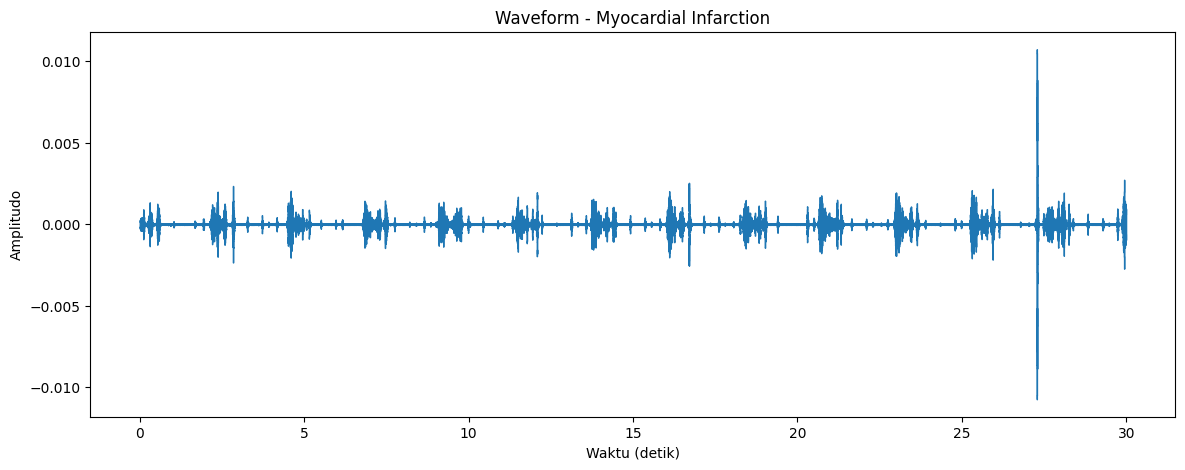

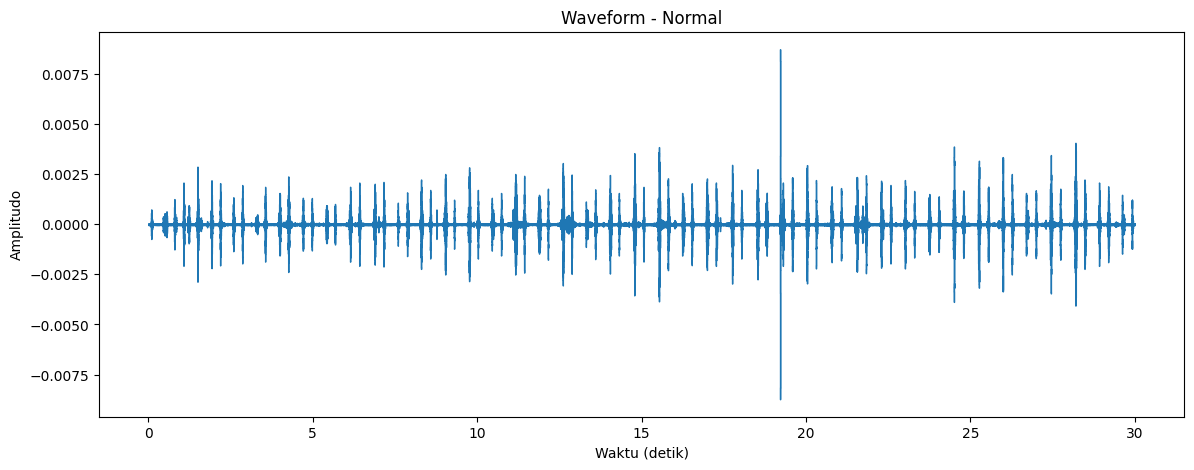

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Pilih satu file audio MI dan satu file audio Normal
sample_MI_file = audio_files_MI[0]
sample_normal_file = audio_files_normal[0]

# Fungsi untuk memvisualisasikan waveform
def plot_waveform(file_path, label):
    y, sr = librosa.load(file_path)
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {label}')
    plt.xlabel('Waktu (detik)')
    plt.ylabel('Amplitudo')
    plt.show()

# Visualisasi waveform untuk MI
plot_waveform(sample_MI_file, 'Myocardial Infarction')

# Visualisasi waveform untuk Normal
plot_waveform(sample_normal_file, 'Normal')


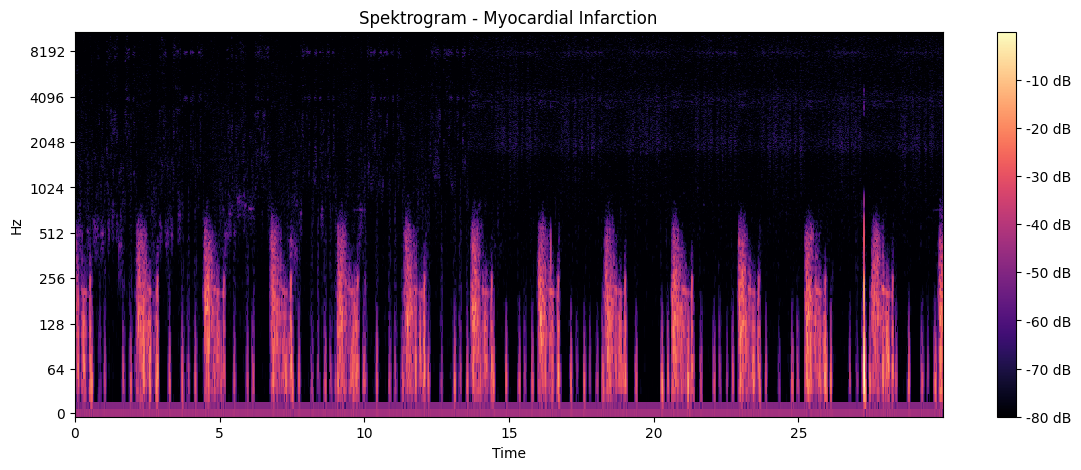

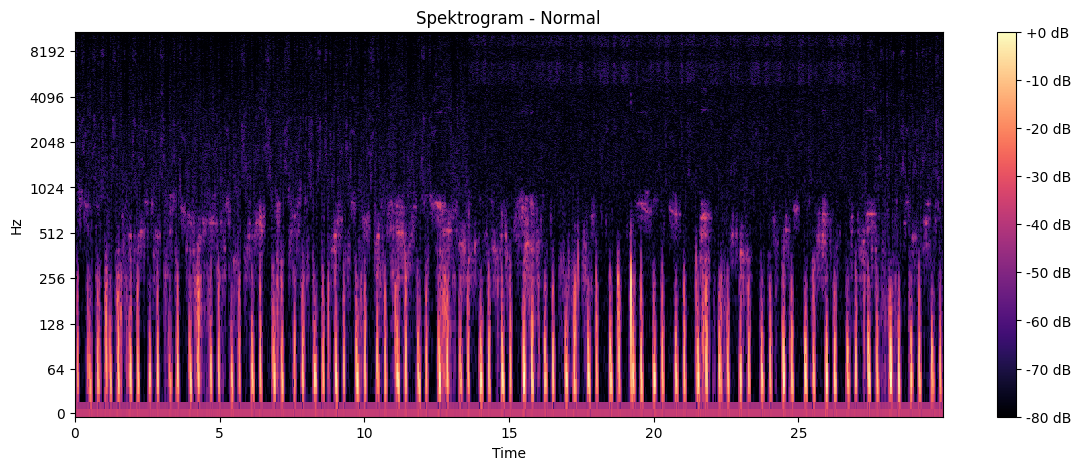

In [ ]:
# Fungsi untuk memvisualisasikan spektrogram
def plot_spectrogram(file_path, label):
    y, sr = librosa.load(file_path)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spektrogram - {label}')
    plt.show()

# Visualisasi spektrogram untuk MI
plot_spectrogram(sample_MI_file, 'Myocardial Infarction')

# Visualisasi spektrogram untuk Normal
plot_spectrogram(sample_normal_file, 'Normal')
